In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [158]:
referrals = pd.read_csv('../clean_data/referrals.csv')
referrers1 = pd.read_csv('../clean_data/referring_providers1.csv')
referrers2 = pd.read_csv('../clean_data/referring_providers2.csv')

referrers1['referrer_entity_type_code'] = referrers1['referrer_entity_type_code'].astype('Int64')
referrers2['referrer_entity_type_code'] = referrers2['referrer_entity_type_code'].astype('Int64')

referrers1['referrer_name'] = (
    referrers1['referrer_first_name'].astype(str).str.strip() +
    " " +
    referrers1['referrer_last_name'].astype(str).str.strip() +
    " "
)

# adds the entity_type_code to the referrals table for each referrer_npi
referrals = referrals.merge(referrers1[['referrer_npi', 'referrer_entity_type_code', 'referrer_specialization', 'referrer_name']], how='left', on='referrer_npi')
referrals = referrals.merge(referrers2[['referrer_npi', 'referrer_entity_type_code', 'referrer_classification', 'referrer_business_name']], how='left', on='referrer_npi')
referrals['referrer_entity_type_code'] = referrals['referrer_entity_type_code_x'].combine_first(referrals['referrer_entity_type_code_y'])
referrals['spec_or_class'] = referrals['referrer_specialization'].combine_first(referrals['referrer_classification'])
referrals['referrer_name'] = referrals['referrer_name'].combine_first(referrals['referrer_business_name'])
referrals = referrals.drop(['referrer_entity_type_code_x', 'referrer_entity_type_code_y', 'referrer_specialization', 'referrer_classification', 'referrer_business_name'], axis=1)

Consolidate the list of hospitals

In [159]:
hosps = referrals[referrals['hosp_grouping'].isin(['Hospital Units', 'Hospitals', 'Hospital'])]
# hosplist = hosps.hosp_business_name.unique().tolist()
# len(hosplist)
renames_businesnames = {
    "BAPTIST WOMEN'S HEALTH CENTER LLC": 'St. Thomas', 
    'SHELBYVILLE HOSPITAL COMPANY LLC': 'Vanderbilt', 
    'HCA HEALTH SERVICES OF TENNESSEE, INC.': 'HCA TriStar', 
    'VANDERBILT STALLWORTH REHABILITATION HOSPITAL LP': 'Vanderbilt', 
    'RIVER PARK HOSPITAL LLC': 'St. Thomas', 
    'HTI MEMORIAL HOSPITAL CORPORATION': 'HCA TriStar', 
    'CENTRAL TENNESSEE HOSPITAL CORPORATION': 'HCA TriStar', 
    'HENDERSONVILLE HOSPITAL CORPORATION': 'HCA TriStar', 
    'SAINT THOMAS WEST HOSPITAL': 'St. Thomas', 
    'VANDERBILT UNIVERSITY MEDICAL CENTER': 'Vanderbilt', 
    'SMITH COUNTY MEMORIAL HOSPITAL, LLC': 'St. Thomas', 
    'SUMNER REGIONAL HEALTH SYSTEMS, INC': 'St. Thomas', 
    'NORTHCREST MEDICAL CENTER': 'HCA TriStar', 
    'NASHVILLE GENERAL HOSPITAL': 'Nashville General', 
    'SAINT THOMAS RUTHERFORD HOSPITAL': 'St. Thomas', 
    'SETON CORPORATION': 'St. Thomas', 
    'SUMNER REGIONAL MEDICAL CENTER LLC': 'St. Thomas', 
    'RIVERVIEW MEDICAL CENTER LLC': 'St. Thomas', 
    'SMITH COUNTY MEMORIAL HOSPITAL LLC': 'St. Thomas', 
    'TROUSDALE MEDICAL CENTER LLC': 'St. Thomas', 
    'RIVERVIEW MEDICAL CENTER, LLC': 'St. Thomas', 
    'SAINT THOMAS RIVER PARK HOSPITAL, LLC': 'St. Thomas', 
    'SAINT THOMAS STONES RIVER HOSPITAL, LLC': 'St. Thomas', 
    'SAINT THOMAS DEKALB HOSPITAL, LLC': 'St. Thomas',
    'MAURY REGIONAL HOSPITAL MARSHALL MEDICAL CENTER': 'MAURY REGIONAL',
    'MAURY REGIONAL HOSPITAL': 'MAURY REGIONAL',
    'ENCOMPASS HEALTH REHABILITATION HOSPITAL OF FRANKLIN, LLC': 'Encompass Health',
    'WILLIAMSON COUNTY HOSPITAL DISTRICT': 'WILLIAMSON CTY HOSP DST',
    'MACON COUNTY GENERAL HOSPITAL': 'MACON CTY GEN HOSP',
}

renames_businesnames = {k.upper(): v.upper() for k, v in renames_businesnames.items()}  # Converts everything to uppercase


reg = r',?\s*(?:INC|LLC)\.?'
def modify_names(x):
    x = renames_businesnames.get(x, x)
    x = re.sub(reg, '', x)
    x = x.replace("HOSPITAL", "HOSP")
    return x

# Modify 'hosp_business_name' column
# hosps['hosp_business_name'] = hosps['hosp_business_name'].apply(lambda x: renames_businesnames.get(x, x))
# hosps['hosp_business_name'] = hosps['hosp_business_name'].apply(lambda x: re.sub(reg, '', x))
# hosps['hosp_business_name'] = hosps['hosp_business_name'].apply(lambda x: x.replace("HOSPITAL", "HOSP"))

df = hosps.copy()
df['hosp_business_name'] = hosps['hosp_business_name'].apply(modify_names)
hosps = df



Consolidate the top specialties

In [160]:
renames_spec = {}
grp = hosps['spec_or_class'].dropna().unique()

# Filter for values containing keywords
vals = [value for value in grp if 'radiology' in value.lower()]
# This gets ['Diagnostic Radiology', 'Radiology', 'Neuroradiology', 'Vascular & Interventional Radiology', 'Therapeutic Radiology', 'Pediatric Radiology', 'Nuclear Radiology']
for val in vals:
    renames_spec[val]="Radiology"

vals = [value for value in grp if 'acute' in value.lower()]
#This gets ['General Acute Care Hospital', 'Acute Care']
for val in vals:
    renames_spec[val]="Acute Care"

vals = [value for value in grp if 'cardio' in value.lower() and 'surgery' not in value.lower()]
#This gets ['Cardiovascular Disease', 'Interventional Cardiology', 'Advanced Heart Failure and Transplant Cardiology', 'Nuclear Cardiology', 'Pediatric Cardiology']
for val in vals:
    renames_spec[val]="Cardiology"


vals = [value for value in grp if 'family' in value.lower()]
#This gets ['Family', 'Family Medicine', 'Family Health']
for val in vals:
    renames_spec[val]="Family"

vals = [value for value in grp if 'laboratory' in value.lower()]
#This gets ['Clinical Medical Laboratory', 'Physiological Laboratory', 'Clinical Pathology/Laboratory Medicine'
for val in vals:
    renames_spec[val]="Laboratory"


# # Modify 'spec_or_class' column
df = hosps.copy()
df['spec_or_class'] = hosps['spec_or_class'].apply(lambda x: renames_spec.get(x, x))
hosps = df


Top 5 hospitals by transactions

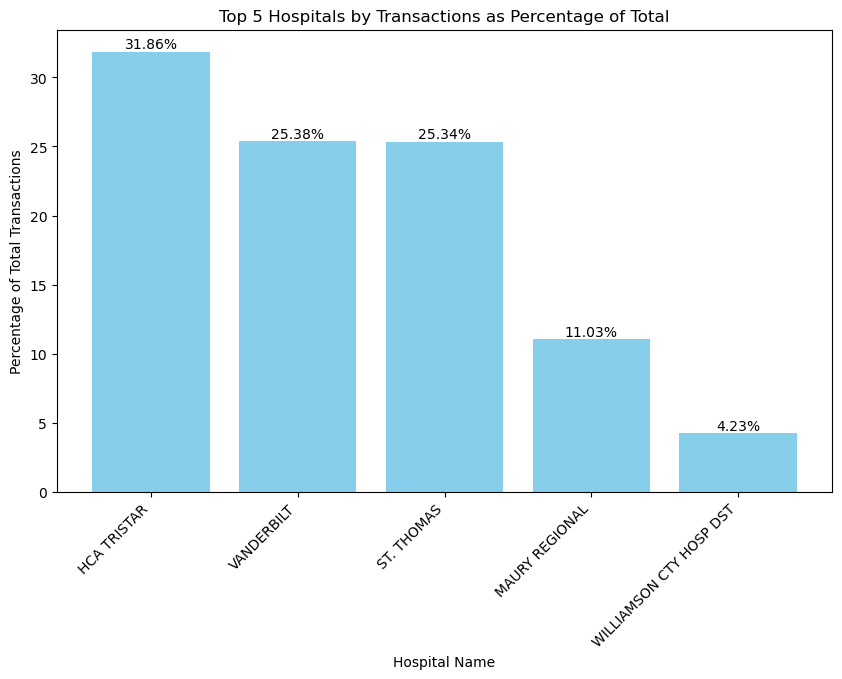

In [161]:
# hosps[['hosp_business_name', 'txns']].groupby('hosp_business_name').sum('txns').sort_values('txns', ascending=False)
hospital_txns = hosps[['hosp_business_name', 'txns']].groupby('hosp_business_name').sum('txns').sort_values('txns', ascending=False)

# Calculate the total transactions
total_txns = hospital_txns['txns'].sum()

# Calculate the percentage of transactions for each hospital
hospital_txns['percentage_of_total'] = hospital_txns['txns'] / total_txns * 100

# Select the top 5 hospitals
top5_hospitals = hospital_txns.head(5)

# Show on a  bar graph
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(top5_hospitals.index, top5_hospitals['percentage_of_total'], color='skyblue')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Display rounded percentages on each bar
for bar in bars:
    yval = round(bar.get_height(), 2)
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}%', ha='center', va='bottom')

plt.title('Top 5 Hospitals by Transactions as Percentage of Total')
plt.xlabel('Hospital Name')
plt.ylabel('Percentage of Total Transactions')
plt.show()


Top 10 referral classifications (excluding Ambulance and Laboratory)

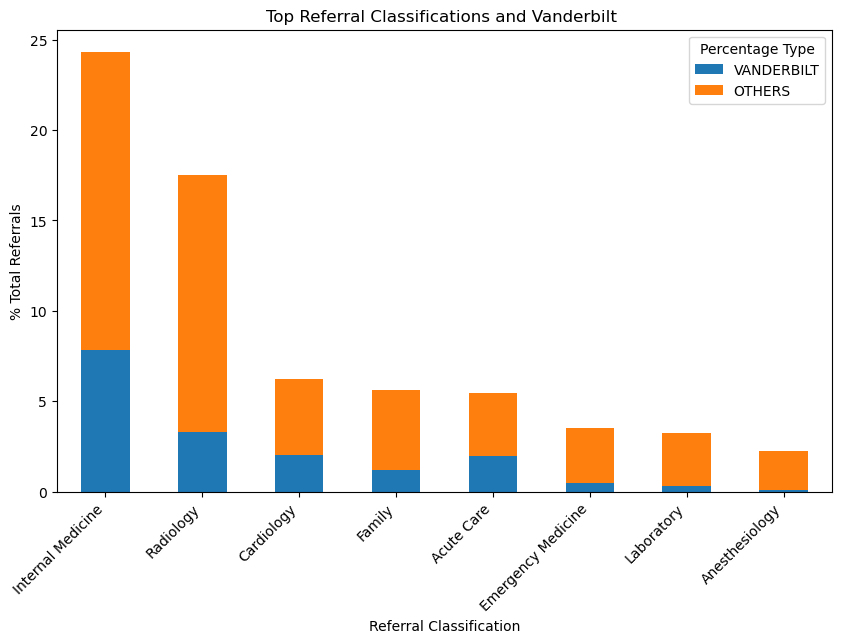

In [162]:
df = hosps[~hosps['spec_or_class'].isin(['Ambulance', 'Specialist'])]
txns_by_class = df[['spec_or_class', 'txns']].groupby('spec_or_class').sum('txns').sort_values('txns', ascending=False)

# Calculate the total transactions
total_txns = txns_by_class['txns'].sum()

# Calculate the percentage of transactions for each hospital
txns_by_class['percentage_of_total'] = txns_by_class['txns'] / total_txns * 100

# Select the top 5 hospitals
topN_class = txns_by_class.head(8).reset_index()  # Reset index to convert the result to a DataFrame

# Calculate Vanderbilt's percentage for each element in 'spec_or_class'
topN_class['VANDERBILT'] = topN_class.apply(
    lambda row: hosps[
        (hosps['hosp_business_name'] == 'VANDERBILT') & (hosps['spec_or_class'] == row['spec_or_class'])
    ]['txns'].sum() / total_txns * 100,
    axis=1
)

# Calculate the percentage of transactions for each hospital
topN_class['OTHERS'] = topN_class['percentage_of_total'] - topN_class['VANDERBILT']

# Plotting the stacked bar graph
fig, ax = plt.subplots(figsize=(10, 6))
topN_class[['VANDERBILT', 'OTHERS']].plot(kind='bar', stacked=True, ax=ax)


# Set x-axis labels
plt.xticks(range(len(topN_class)), topN_class['spec_or_class'], rotation=45, ha='right')

plt.title('Top Referral Classifications and Vanderbilt ')
plt.xlabel('Referral Classification')
plt.ylabel('% Total Referrals')
plt.legend(title='Percentage Type', loc='upper right')
plt.show()


Where do most referrals go? 

In [163]:
top_referring_specialties = topN_class["spec_or_class"].tolist()
print(top_referring_specialties)
ordered_by_rank = ['Internal Medicine', 'Cardiology',  'Acute Care', 'Emergency Medicine', 'Radiology','Family','Laboratory','Anesthesiology']


['Internal Medicine', 'Radiology', 'Cardiology', 'Family', 'Acute Care', 'Emergency Medicine', 'Laboratory', 'Anesthesiology']


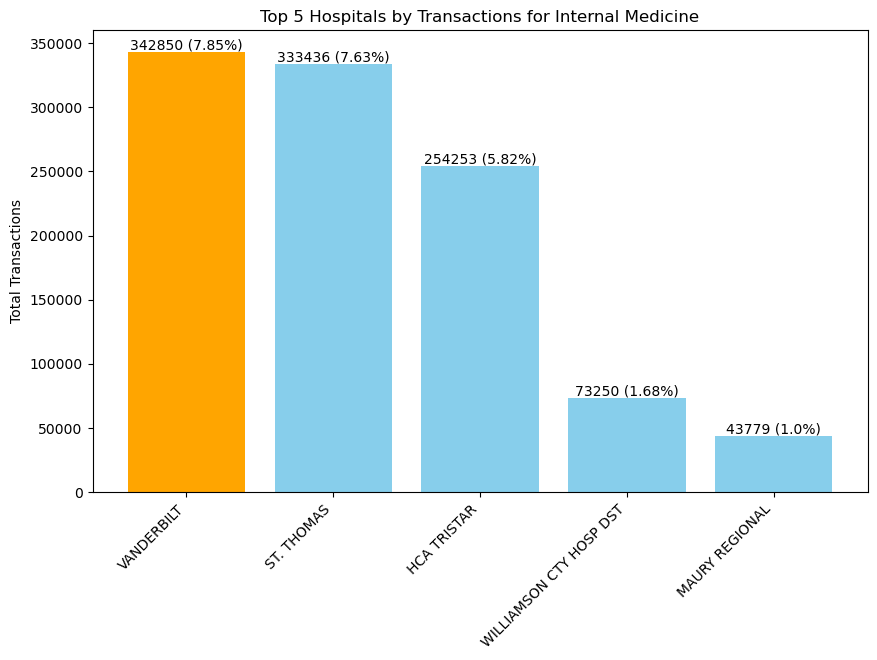

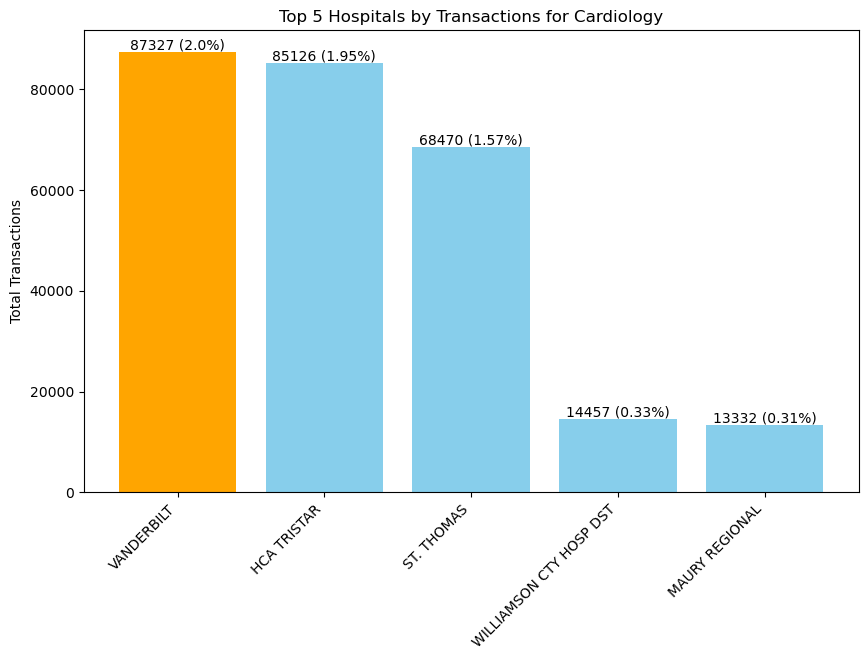

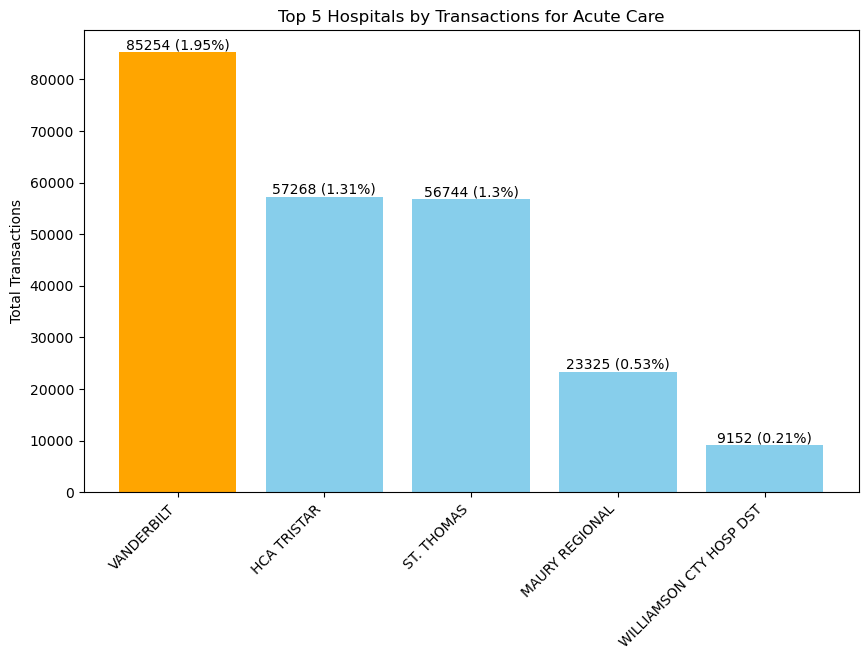

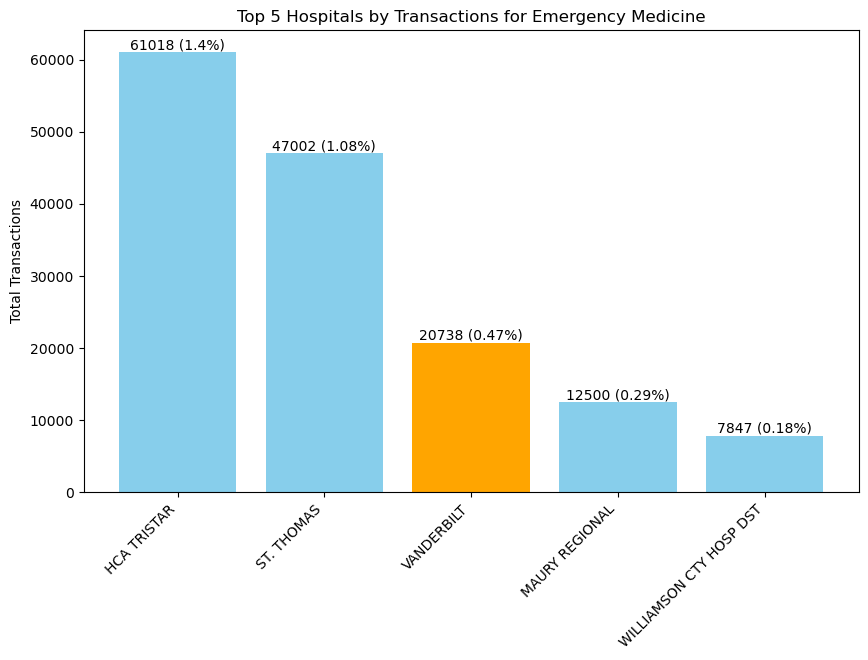

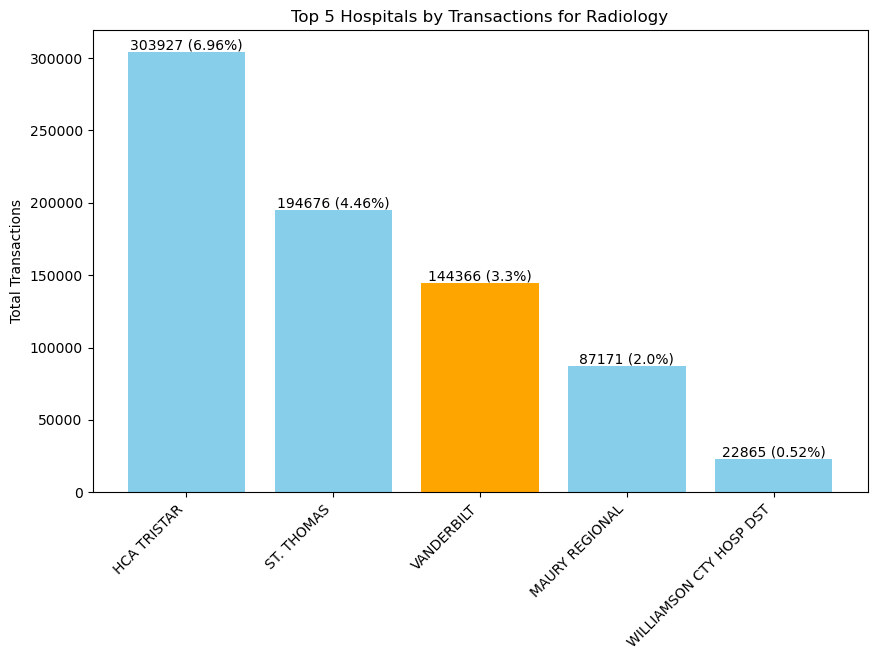

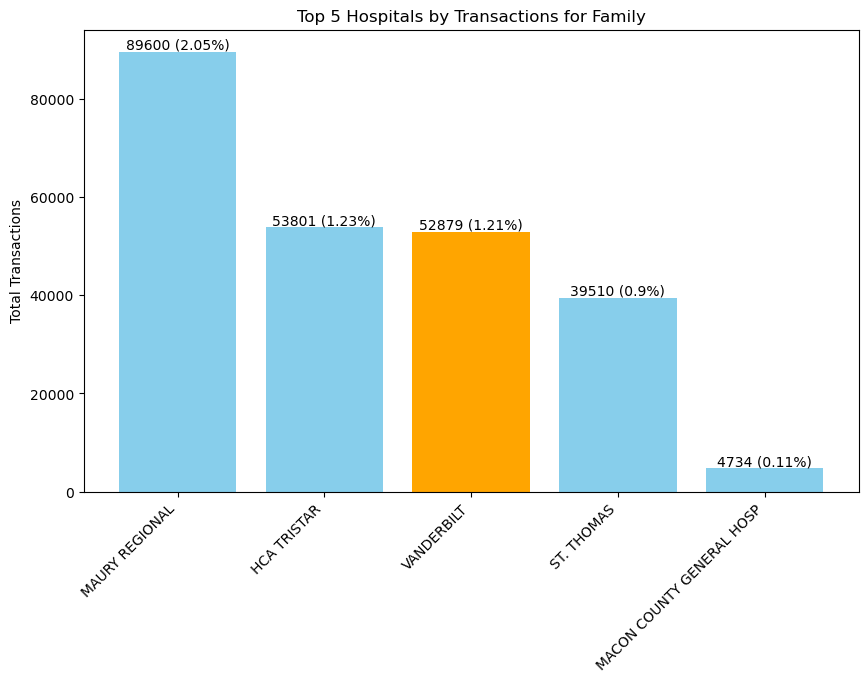

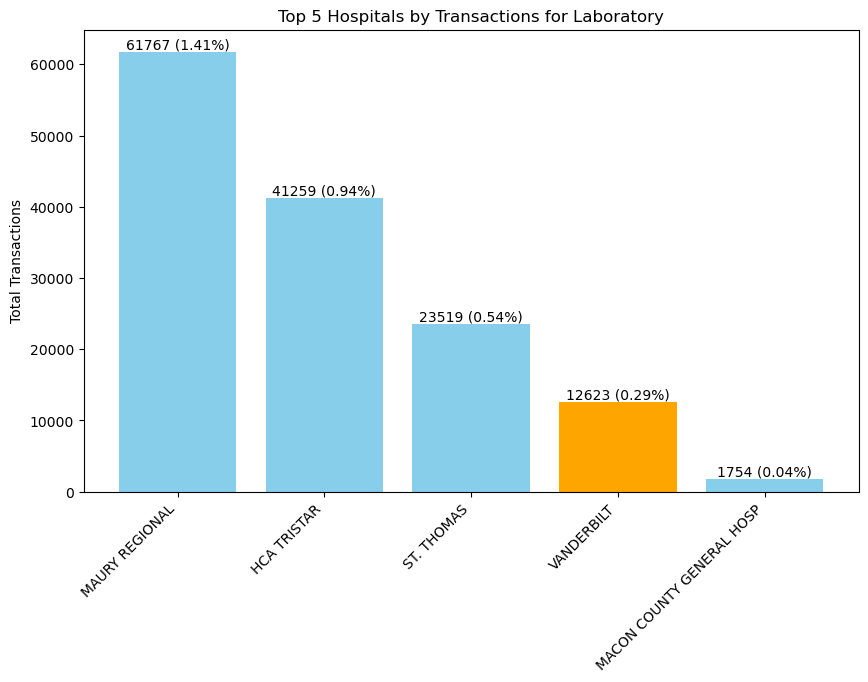

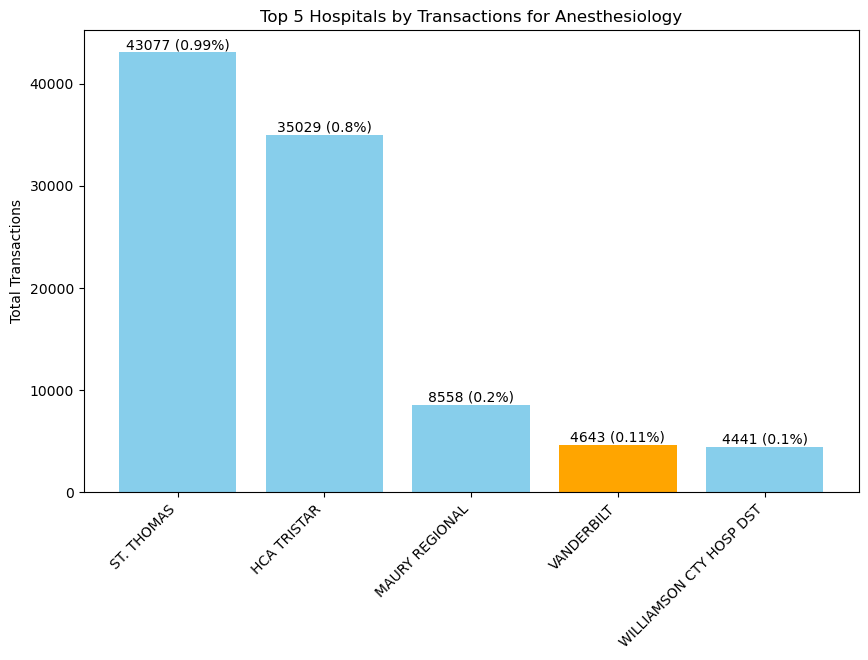

In [164]:

def make_specialties_plot(spec):
    df = hosps[hosps['spec_or_class'] == spec]
    hospital_txns = df[['hosp_business_name', 'txns']].groupby('hosp_business_name').sum('txns').sort_values('txns', ascending=False)

    # Select the top 5 hospitals
    top5_hospitals = hospital_txns.head(5)

    # Identify the index of the Vanderbilt hospital
    vanderbilt_index = top5_hospitals.index.get_loc('VANDERBILT') if 'VANDERBILT' in top5_hospitals.index else None


    colors = ['orange' if i == vanderbilt_index else 'skyblue' for i in range(len(top5_hospitals))]
    # Show on a  bar graph
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(top5_hospitals.index, top5_hospitals['txns'], color=colors)

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')


    # Display total transactions and rounded percentages on each bar
    for bar in bars:
        yval = round(bar.get_height(), 2)
        percentage = round((yval / total_txns) * 100, 2)
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval} ({percentage}%)', ha='center', va='bottom')

    plt.title(f'Top 5 Hospitals by Transactions for {spec}')
    plt.ylabel('Total Transactions')
    plt.show()

for spec in ordered_by_rank:
    make_specialties_plot(spec)


# EVERYTHING BELOW IS JUNK

In [85]:
# Top individual referrers
df = hosps[hosps['referrer_entity_type_code']==1]
df.groupby(by='referrer_npi')['txns'].sum().sort_values(ascending=False)[0:10]

referrer_npi
1093753303    33308
1417131715    10271
1043232879     7087
1043228935     6686
1134321235     6409
1174517593     5923
1871548818     5400
1679689285     5357
1912984758     5346
1306993282     4916
Name: txns, dtype: int64

In [ ]:
npi = 1093753303
print(referrers1[referrers1['referrer_npi']==npi][['referrer_first_name', 'referrer_last_name', 'referrer_credential']])
hosps[hosps['referrer_npi']==npi].groupby(by='referrer_npi').agg({
    'txns': 'sum',
    'hosp_business_name': 'first',
    'hosp_grouping': 'first',
    'hosp_classification': 'first',
    'hosp_zip_code': 'first',
    'hosp_city': 'first',
    'hosp_state': 'first',
    'referrer_specialization': 'first'
}).sort_values(by='txns', ascending=False)

In [ ]:
# Top intitutional referrers
df = hosps[hosps['referrer_entity_type_code']==2]
df.groupby(by='referrer_npi')['txns'].sum().sort_values(ascending=False)[0:10]

In [ ]:
npi = 1649228735
print(referrers2[referrers2['referrer_npi']==npi][['referrer_business_name']])
hosps[hosps['referrer_npi']==npi].groupby(by='referrer_npi').agg({
    'txns': 'sum',
    'hosp_business_name': 'first',
    'hosp_grouping': 'first',
    'hosp_classification': 'first',
    'hosp_zip_code': 'first',
    'hosp_city': 'first',
    'hosp_state': 'first',
    'referrer_classification': 'first'
}).sort_values(by='txns', ascending=False)

In [ ]:
vandy_refs = referrals[referrals['hosp_business_name'].str.lower().str.contains('vand')]
# referrals[referrals['hosp_business_name'].str.lower().str.contains('baptist')].shape
# vandy_refs = referrals[referrals['hosp_npi'] == 1821030842]

In [ ]:
vandy_refs.groupby(by='referrer_npi')['txns'].sum().sort_values(ascending=False)

In [ ]:
vandy_refs['hosp_business_name'].value_counts()

In [ ]:
vandy_refs[vandy_refs.hosp_business_name ==  'VANDERBILT UNIVERSITY MEDICAL CENTER'].shape

In [ ]:
hosps.shape

In [ ]:
hosps.groupby(by='referrer_npi')['txns'].sum().sort_values(ascending=False)

In [ ]:
referrers2[referrers2['referrer_npi']==1861478489]

In [ ]:
referrals[referrals['hosp_grouping'].str.lower().str.contains('ascension')]

In [ ]:
referrals[referrals['hosp_npi']==1861638645]

In [ ]:
txns_by_class

In [ ]:
referrals[referrals['hosp_npi'] == 1669567897]

In [ ]:
txns_by_class = hosps[['spec_or_class', 'txns']].groupby('spec_or_class').sum('txns').sort_values('txns', ascending=False)

# Calculate the total transactions
total_txns = txns_by_class['txns'].sum()

# Calculate the percentage of transactions for each hospital
txns_by_class['percentage_of_total'] = txns_by_class['txns'] / total_txns * 100

# Select the top 5 hospitals
topN_class = txns_by_class.head(10).reset_index()  # Reset index to convert the result to a DataFrame

# Calculate Vanderbilt's percentage for each element in 'spec_or_class'
topN_class['vandy_share'] = topN_class.apply(
    lambda row: hosps[
        (hosps['hosp_business_name'] == 'Vanderbilt') & (hosps['spec_or_class'] == row['spec_or_class'])
    ]['txns'].sum() / total_txns * 100,
    axis=1
)

# Calculate the percentage of transactions for each hospital
topN_class['percentage_of_total'] = topN_class['percentage_of_total'] - topN_class['vandy_share']

# Plotting the stacked bar graph
fig, ax = plt.subplots(figsize=(10, 6))
topN_class[['vandy_share', 'percentage_of_total']].plot(kind='bar', stacked=True, ax=ax)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Set x-axis labels
plt.xticks(range(len(topN_class)), topN_class['spec_or_class'], rotation=45, ha='right')

plt.title('Percentage of Total and Vanderbilt\'s Percentage by Referral Classification')
plt.xlabel('Referral Classification')
plt.ylabel('Percentage')
plt.legend(title='Percentage Type', loc='upper right')
plt.show()

In [ ]:
topN_class

In [ ]:
hosplist = hosps.hosp_business_name.unique().tolist()
for h in hosplist:
    print(h, len(h))

In [ ]:
for h in hosplist:
    print(h, len(h))